In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
def load_data():
    # 加载数据MNIST, 训练集和测试集(train=True/False), 转换为张量(附带归一化 /255), 下载数据
    train_data = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)
    
    # 数据加载器 DataLoader, 用于将数据分批次加载, shuffle=True表示打乱数据
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=256, shuffle=False)
    return train_loader, test_loader

In [10]:
# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


In [11]:
# 训练函数
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 将数据移到GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Train Loss: {total_loss / len(train_loader):.4f}')

In [12]:
# 测试函数
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # 将数据移到GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

In [13]:
# 可视化一些测试结果
def visualize_predictions(model, loader, device):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i][0].cpu(), cmap='gray')
        plt.title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()


In [16]:
# 主程序
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

train_loader, test_loader = load_data()
model = CNN().to(device)
criterion = nn.NLLLoss()  # 或者使用 nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    train(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, device)


Device:  cuda
Epoch [1/5]
Train Loss: 0.3430
Accuracy of the model on the test set: 96.83%
Epoch [2/5]
Train Loss: 0.0772
Accuracy of the model on the test set: 98.31%
Epoch [3/5]
Train Loss: 0.0526
Accuracy of the model on the test set: 98.55%
Epoch [4/5]
Train Loss: 0.0406
Accuracy of the model on the test set: 98.34%
Epoch [5/5]
Train Loss: 0.0346
Accuracy of the model on the test set: 98.53%


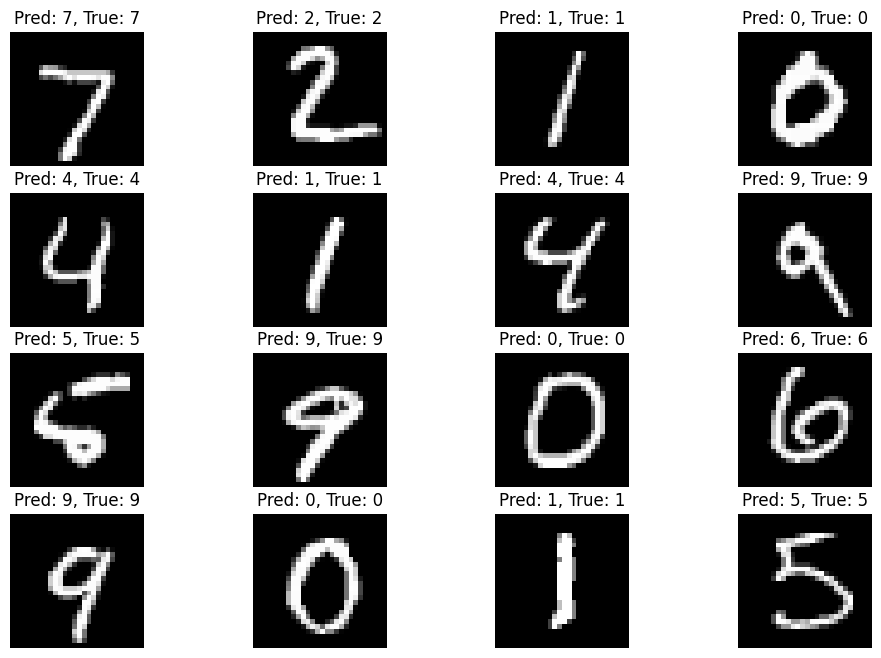

In [15]:
# 可视化测试结果
visualize_predictions(model, test_loader, device)